In [1]:
import sys
sys.path.append('../')

from model import DecisionTree
from rule import RuleExtractor

import os
import numpy as np
import warnings
import pandas as pd

np.set_printoptions(suppress=True)

warnings.filterwarnings(action='ignore')

In [3]:
# sage, srgnn 중 선택
embed_model = 'srgnn'
filename = {'sage' : 'user_embedding_sage_sid_6to6_weighted.npy', 'srgnn' : 'srgnn_user_hybrid_6to6_weighted.npy'}
data_path = "../data/"

pivot_df = pd.read_csv(os.path.join(data_path, 'pivot_genre2_data.csv'), index_col=0)
embedding = np.load(os.path.join(data_path, filename[embed_model]))

# One vs Rest Decision Tree

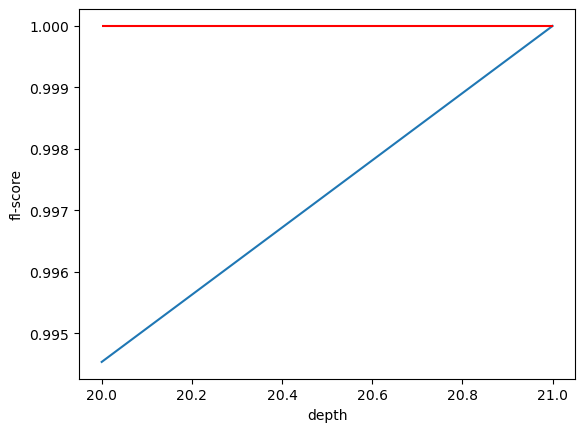

21 1.0


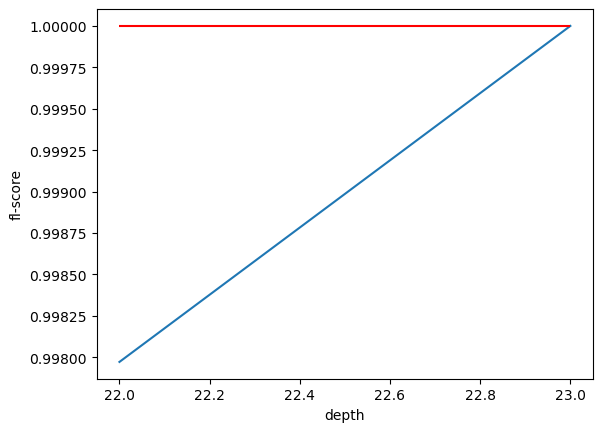

23 1.0


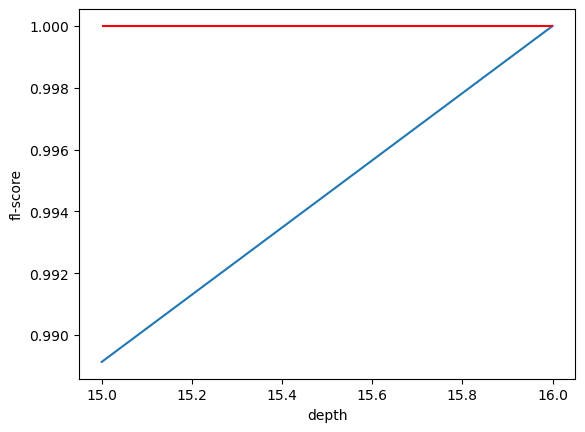

16 1.0


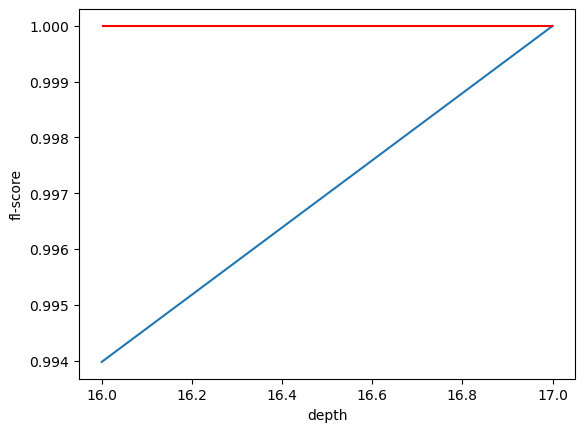

17 1.0


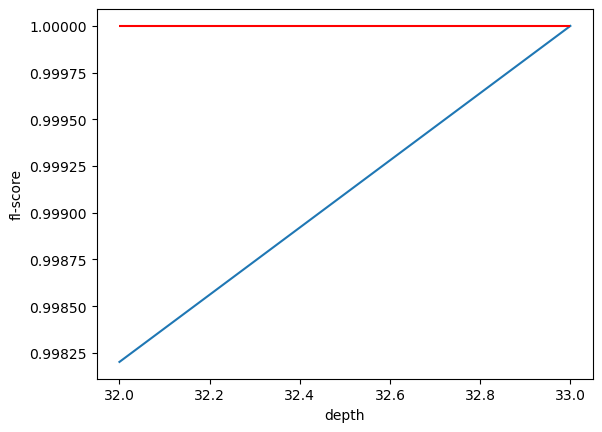

33 1.0


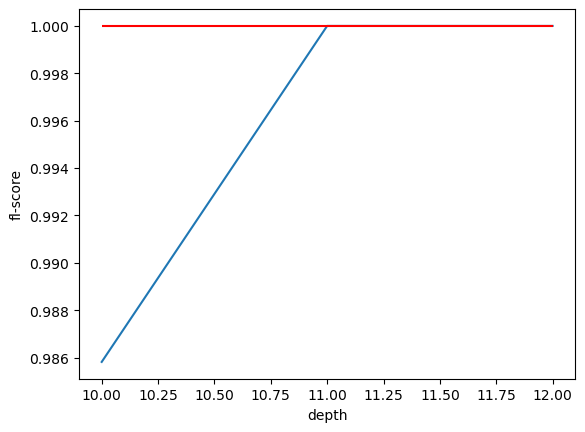

11 1.0


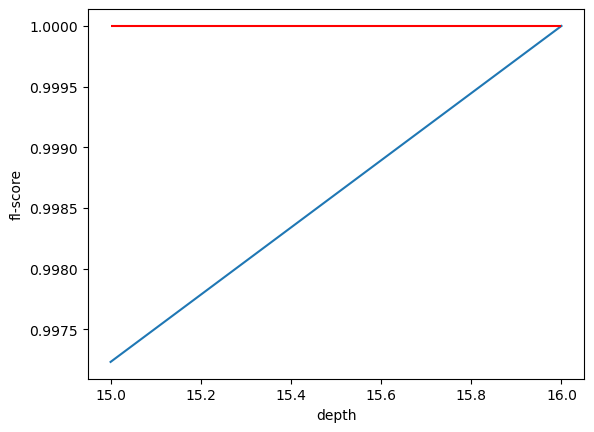

16 1.0


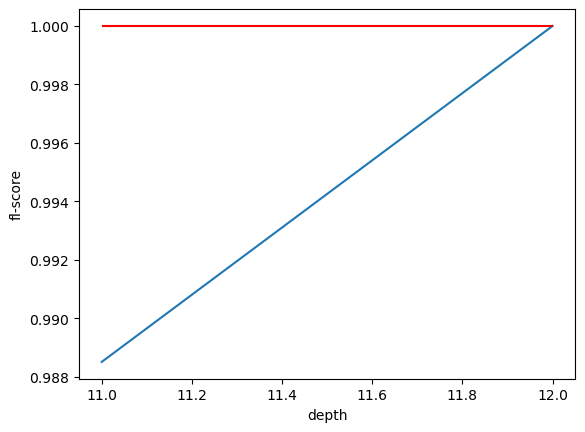

12 1.0


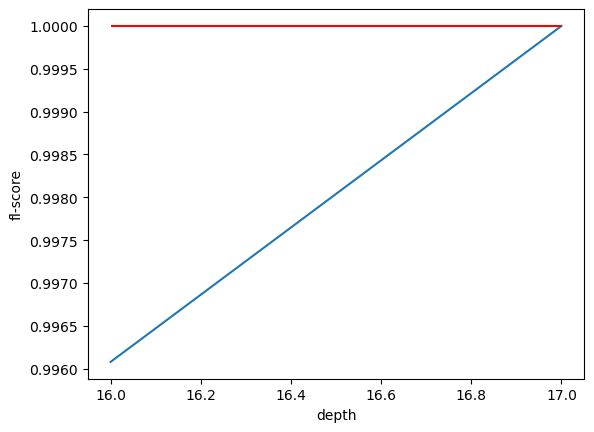

17 1.0


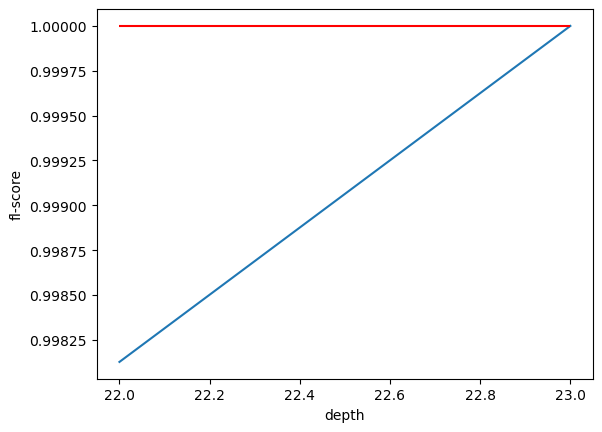

23 1.0


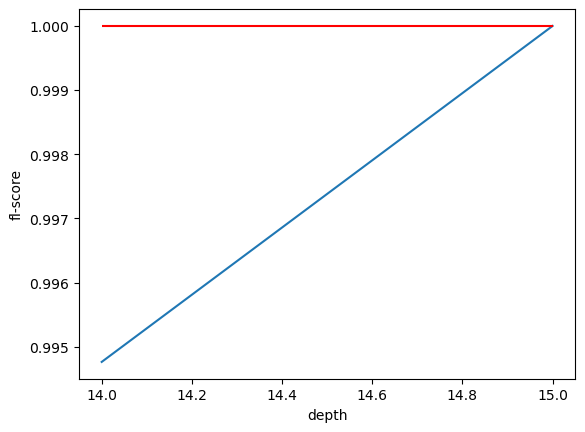

15 1.0


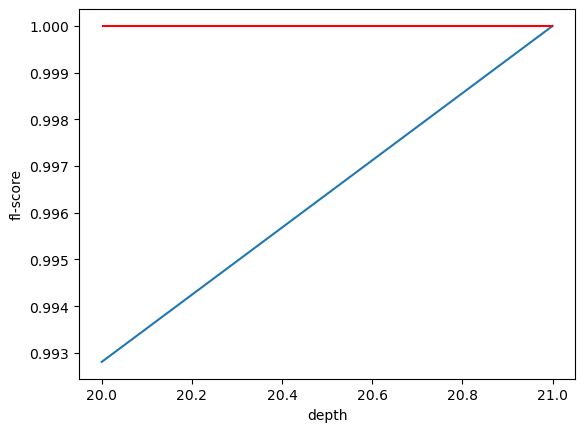

21 1.0


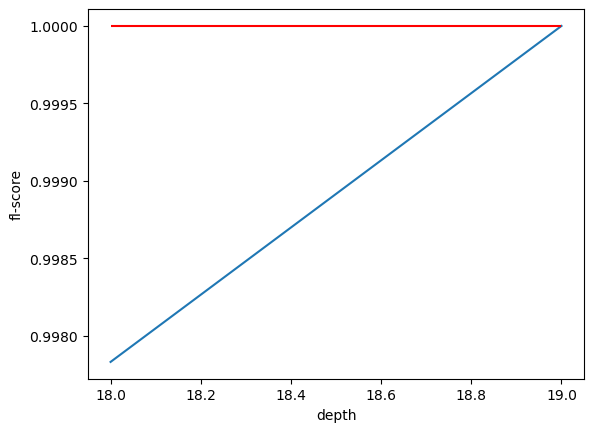

19 1.0


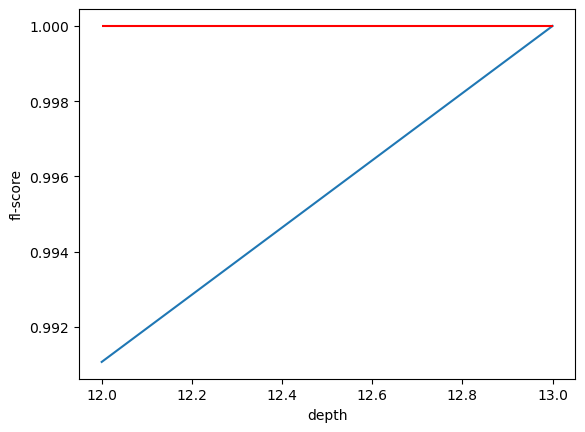

13 1.0


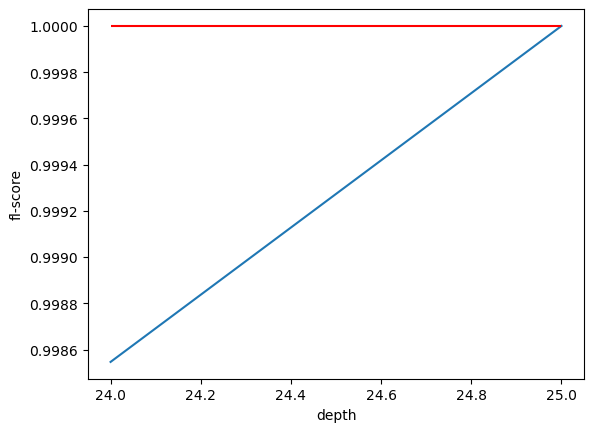

25 1.0


In [7]:
model = DecisionTree(pivot_df, embedding)
k = 15
result = []
for i in range(k):
    model.kmeans_target(i)
    max_depth, max_score = model.get_proper_depth(target_score=1.0, scoring='recall')

    result.append((max_depth, max_score))
    print(max_depth, max_score)

    rule_extractor = RuleExtractor(model)
    rules = rule_extractor.extract_rule(segment_num=1)
    
    with open(f'../output/{embed_model}_rule/{embed_model}_seg_rule_extract{i}.txt', 'w') as f:
        f.writelines(rules)

In [10]:
# one vs rest decision tree 평균 depth
np.mean([r[0] for r in result])

18.8

# Multi-Class Decision Tree

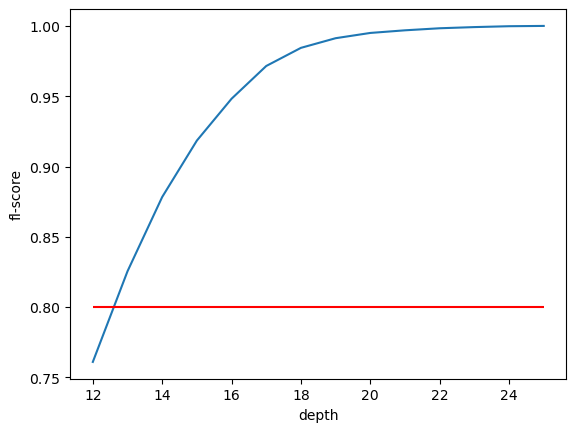

13 0.8254991680532446


In [8]:
model = DecisionTree(pivot_df, embedding)
max_depth, max_score = model.get_proper_depth(target_score=0.8, scoring='f1_score')
print(max_depth, max_score)
rule_extractor = RuleExtractor(model)

k = 15
for i in range(k):
    rules = rule_extractor.extract_rule(segment_num=i)
    
    with open(f'../output/{embed_model}_rule/{embed_model}_seg_rule_extract{i}.txt', 'w') as f:
        f.writelines(rules)